In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats
from operator import itemgetter
import collections
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman

In [2]:
column_name = ['wikipedia_id', 
               'freebase_id', 
               'release_date', 
               'character_name', 
               'actor_dob', 
               'actor_gender', 
               'actor_height', 
               'actor_ethnicity', 
               'actor_name', 
               'actor_age', 
               'freebase_character_map', 
               'freebase_character_id', 
               'freebase_actor_id']

In [3]:
df=pd.read_csv('character.metadata.tsv', sep='\t', names=column_name)

In [4]:
df.shape

(450669, 13)

In [5]:
df.head(10)

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy


In [6]:
num = df.isna().sum()

In [7]:
num

wikipedia_id                   0
freebase_id                    0
release_date                9995
character_name            257875
actor_dob                 106145
actor_gender               45609
actor_height              295845
actor_ethnicity           344611
actor_name                  1228
actor_age                 158113
freebase_character_map         0
freebase_character_id     257865
freebase_actor_id            815
dtype: int64

# Analyze the structural gender difference under the social graph of actors #

In [8]:
# Helper function for plotting the degree distribution of a Graph
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")

In [9]:
# Helper function for printing various graph properties
def describe_graph(G):
    print(nx.info(G))
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

In [10]:
# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

In [11]:
df_actor_name = df.dropna(subset = ['actor_name', 'actor_gender'])
df_actor_name.head(10)

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy


In [12]:
len(df_actor_name)

405048

In [13]:
df_actor_name.isna().sum()

wikipedia_id                   0
freebase_id                    0
release_date                9846
character_name            219588
actor_dob                  62635
actor_gender                   0
actor_height              250385
actor_ethnicity           299037
actor_name                     0
actor_age                 114290
freebase_character_map         0
freebase_character_id     219580
freebase_actor_id              0
dtype: int64

In [14]:
df_actor_name_id = df_actor_name.drop_duplicates(subset=['freebase_actor_id'])
df_actor_name_id.set_index('freebase_actor_id', inplace = True)
df_actor_name_id.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id
freebase_actor_id,,,,,,,,,,,,
/m/03wcfv7,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x
/m/0346l4,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4
/m/01vw26l,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_
/m/034hyc,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq
/m/01y9xg,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9


In [15]:
# make a dict to contain the actor freebase IDs under the same movie
dict_movies = {}
for index, row in df_actor_name.iterrows():
    if row['wikipedia_id'] not in dict_movies.keys():
        dict_movies[row['wikipedia_id']] = [row['freebase_actor_id']]
    else:
        dict_movies[row['wikipedia_id']].append(row['freebase_actor_id'])

In [16]:
# delete the repeated actor freebase IDs and use the number symbol to replace in order to change it to the nodes on the graph
df_nodes = df_actor_name.freebase_actor_id[df_actor_name.freebase_actor_id.duplicated() == False]

dict_id = {}  # exchange between actor freebase IDs and number symbol
df_nodes_list = list(df_nodes)
for i in range(len(df_nodes_list)):
    dict_id[df_nodes_list[i]] = i
    
df_nodes_id = df_nodes.apply(lambda x: dict_id[x]+1)
df_nodes_id[:10]

0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
Name: freebase_actor_id, dtype: int64

In [17]:
# find out all partnership between actors and use the number symbol to replace in order to change it to the edges on the graph
source = []
target = []
attribute = []
for key, value in dict_movies.items():
    value_edges = list(itertools.combinations(value, 2))
    for i in range(len(value_edges)):
        source.append(dict_id[value_edges[i][0]]+1)
        target.append(dict_id[value_edges[i][1]]+1)
        attribute.append(key)

Now we start to build up the graph with the prepared nodes and edges data. We use `nx.Graph()` to generate an empty undirected graph and load our prepared data. In our social network graph, every actor represents a node and there is a edge between two nodes if the two actors have cooperated at least one movies. The more degrees the node has, the more influential the actor is. First we will analyze the `Top100` most influential actors' gender and height difference preliminarily, and then draw out their social relationship topology. `In the next stage`, we will do some deeper analysis from the structure of social realtionship topology.

In [18]:
# generate a graph
G = nx.Graph()
# load the nodes data
nodes_id = list(df_nodes_id)
G.add_nodes_from(nodes_id)

print(nodes_id[:10])
print(len(G.nodes))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
97379


In [19]:
# load the edges data
count1 = []
count2 = 0
for i in range(len(source)):
    if source[i] > target[i]:
        c = source[i]
        source[i] = target[i]
        target[i] = c
    if source[i] == target[i]:
        count1.append(i)
        count2 += 1

In [20]:
# add the weight and movie ID attributes to the edges
for i in range(len(source)):
    weight = 1
    if source[i] != target[i]:
        G.add_edge(source[i], target[i])
        if 'weight' not in G.edges[source[i], target[i]].keys():
            G.edges[source[i], target[i]]['weight'] = weight
            G.edges[source[i], target[i]]['wikipedia_id'] = [attribute[i]]
        else:
            G.edges[source[i], target[i]]['weight'] += 1
            G.edges[source[i], target[i]]['wikipedia_id'].append(attribute[i]) 

In [21]:
# There is no attributes in the nodes now
G.nodes[1]

{}

In [22]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 97379
Number of edges: 1718283
Average degree:  35.2906


In [23]:
describe_graph(G)

Name: 
Type: Graph
Number of nodes: 97379
Number of edges: 1718283
Average degree:  35.2906
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0004
Global clustering coefficient aka Transitivity: 0.1327


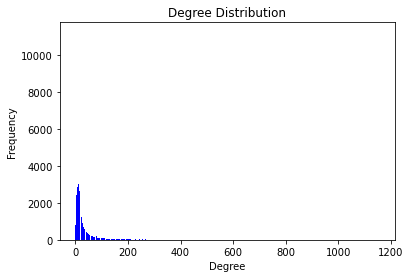

In [24]:
plot_degree_distribution(G)

In [26]:
# connected components
comp = list(nx.connected_components(G))
print('The graph contains', len(comp), 'connected components')

The graph contains 1595 connected components


In [27]:
largest_comp = max(comp, key=len)
percentage_lcc = len(largest_comp)/G.number_of_nodes() * 100
print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes') 

The largest component has 91876 nodes accounting for 94.35 % of the nodes


In [28]:
# add the gender feature to the nodes in graph
gender_dict = {}
error_number = []
for key, value in dict_id.items():
    try:
        gender_dict[value+1] = df_actor_name_id.loc[key].actor_gender
    except:
        error_number.append(value+1)
nx.set_node_attributes(G, gender_dict, 'gender' )

In [29]:
G.nodes[1]

{'gender': 'F'}

In [30]:
# for gender attributes
nx.attribute_assortativity_coefficient(G, 'gender')

0.026499667110727498

There is no notion of *gender homophily* in this network, which makes sense due to the `gender imblance`

In [31]:
# creat the male subgraph and female subgraph
male = []
female = []
for i in G.nodes():
    if G.nodes[i]['gender'] == 'M':
        male.append(i)
    if G.nodes[i]['gender'] == 'F':
        female.append(i)
G_male = G.subgraph(male)
G_female = G.subgraph(female)

In [32]:
describe_graph(G_male)

Name: 
Type: Graph
Number of nodes: 61517
Number of edges: 773898
Average degree:  25.1605
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0004
Global clustering coefficient aka Transitivity: 0.1349


In [33]:
describe_graph(G_female)

Name: 
Type: Graph
Number of nodes: 35862
Number of edges: 200989
Average degree:  11.2090
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0003
Global clustering coefficient aka Transitivity: 0.1486


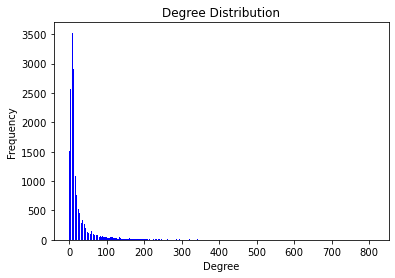

In [34]:
plot_degree_distribution(G_male)

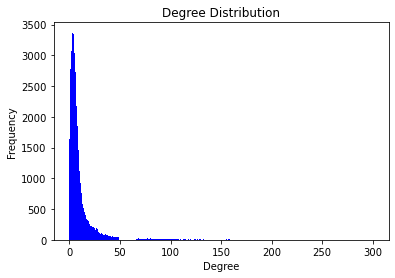

In [35]:
plot_degree_distribution(G_female)

In [36]:
# Sort the actors with the degree of nodes and print the top10 
dict_degree = dict(G.degree())
result = sorted(dict_degree.items(), key = lambda x: x[1], reverse = True)
result100 = [i[0]-1 for i in result[:100]]

print('The first is the number symbol of actors and the second is its corresponding degree')
result[:10]

The first is the number symbol of actors and the second is its corresponding degree


[(5368, 1157),
 (1347, 1056),
 (1963, 1012),
 (3492, 1007),
 (2787, 989),
 (3051, 975),
 (4607, 955),
 (887, 945),
 (429, 940),
 (5762, 929)]

In [37]:
# Helper function for using number symbol to find the corresponding actor name
def find_actor_name_by_number(n):
    query = list(dict_id.keys())[n-1]
    actor_name = df_actor_name_id.loc[query].actor_name
    return actor_name

In [42]:
# an example two famous actors
print(find_actor_name_by_number(1347))
print(find_actor_name_by_number(5368))
print(find_actor_name_by_number(2105))

Christopher Lee
Samuel L. Jackson
Whoopi Goldberg


In [39]:
# generate a new Top 100
G100 = G.subgraph([i[0] for i in result[:100]])

In [40]:
subgraph_male = G.subgraph([5368]+list(G100.neighbors(5368)))
subgraph_female = G.subgraph([2105]+list(G100.neighbors(2105)))

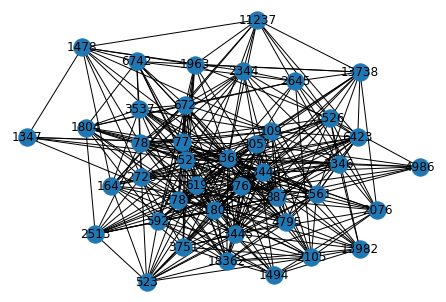

In [41]:
# draw out the subgraph with most famous male actor Samuel L. Jackson (5368)
nx.draw_spring(subgraph_male, with_labels=True)

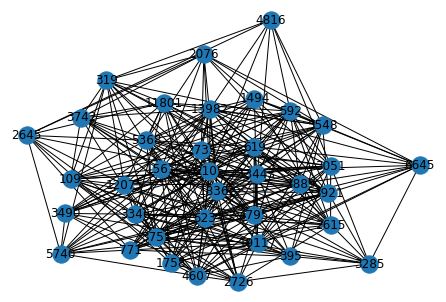

In [43]:
# draw out the subgraph with most famous female actor Whoopi Goldberg (2105)
nx.draw_spring(subgraph_female, with_labels=True)

In [44]:
print(nx.clustering(G, [5368, 2105]))

{5368: 0.038923597300021234, 2105: 0.05126912763855567}


In [45]:
print(nx.clustering(G100, [5368, 2105]))

{5368: 0.38461538461538464, 2105: 0.4365079365079365}


##### It is interesting that although male actors's nodes have more average degrees in male subgraph, which means that there are more cooperations in the film and television industry between male actors, female actors actually have more stable partnerships with female actors accroding to the higher transitivity value of gender subgraphs and higher clustering coefficient of specific actors . #####

##### One convincing explanation is that the number of female actors is less than the male actors, so for every specific kind of female character in the movies, there are few potiental female candidates, and that is why there is more stable cooperation relationship between female actors . #####

In [46]:
# use louvain algorithm to detect the groups
partition = community_louvain.best_partition(G100, weight = 'weight')
# add it as an attribute to the nodes
for n in G100.nodes:
    G100.nodes[n]["louvain"] = partition[n]

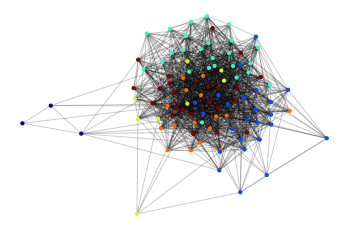

In [47]:
# plot it out
pos = nx.spring_layout(G100,k=0.1)
ec = nx.draw_networkx_edges(G100, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G100, pos, nodelist=G100.nodes(), node_color=[G100.nodes[n]["louvain"] for n in G100.nodes], 
                            node_size=10, cmap=plt.cm.jet)
plt.axis('off')
plt.show()

In [48]:
# specific groups in G100
partition

{1546: 0,
 523: 3,
 2573: 1,
 11801: 3,
 8218: 2,
 1561: 5,
 3612: 1,
 2076: 2,
 1567: 1,
 3109: 1,
 2615: 4,
 2617: 2,
 2105: 2,
 1081: 1,
 77: 5,
 78: 5,
 592: 5,
 593: 3,
 2645: 5,
 6742: 5,
 2648: 4,
 9816: 2,
 609: 3,
 1129: 1,
 619: 3,
 5740: 2,
 109: 5,
 1647: 4,
 3200: 1,
 5762: 5,
 13443: 5,
 13445: 5,
 3742: 1,
 3743: 1,
 13982: 2,
 672: 5,
 2726: 5,
 3751: 5,
 19117: 4,
 2735: 2,
 4795: 5,
 703: 2,
 1728: 2,
 4816: 5,
 3285: 1,
 1758: 1,
 3807: 1,
 2787: 1,
 2275: 0,
 5368: 5,
 771: 2,
 772: 2,
 2309: 1,
 1804: 5,
 5903: 2,
 3344: 2,
 3346: 3,
 277: 3,
 6423: 4,
 2842: 4,
 10011: 3,
 4903: 5,
 2344: 4,
 2346: 4,
 12075: 2,
 2349: 5,
 3889: 4,
 823: 2,
 319: 1,
 1347: 1,
 3921: 4,
 10093: 4,
 367: 2,
 887: 5,
 4986: 4,
 395: 4,
 1431: 2,
 3490: 2,
 3492: 1,
 13738: 4,
 1963: 1,
 5548: 2,
 429: 1,
 18362: 5,
 1986: 1,
 1478: 1,
 4041: 0,
 2513: 1,
 3537: 5,
 1489: 5,
 1494: 2,
 11237: 1,
 3051: 4,
 5102: 1,
 1525: 5,
 1526: 4,
 6645: 2,
 2042: 2,
 6142: 2,
 4607: 2}

In [49]:
female = 0
female_height = []
female_set = []
male = 0
male_height = []
male_set = []
error = []
for i in result100:
    query = df_nodes_list[i]
    gender = df_actor_name_id.loc[query].actor_gender
    if gender == 'F':
        female += 1
        female_set.append(i)
        female_height.append(df_actor_name_id.loc[query].actor_height)
    elif gender == 'M':
        male += 1
        male_set.append(i)
        male_height.append(df_actor_name_id.loc[query].actor_height)
    else:
        error.append(df_actor_name_id.loc[query].actor_name)
print('The number of female and male in Top100 ranking are {} and {}'.format(female, male))
print('The number of gender missing value in Top100 result is {}'.format(len(error)))

The number of female and male in Top100 ranking are 8 and 92
The number of gender missing value in Top100 result is 0


In [50]:
# the female names in Top100 actors
female_set

[18361, 2104, 1727, 3920, 8217, 3741, 1525, 2841]

Text(0, 0.5, 'population')

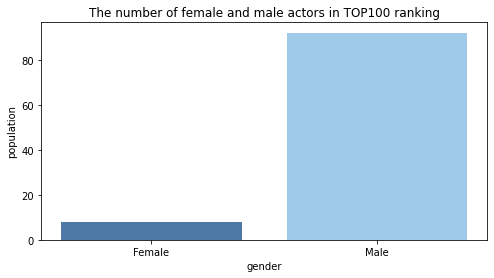

In [51]:
# plot the histogram
plt.figure(figsize = (8,4))
data = [female, male]
labels = ['Female', 'Male']
colors = ["#4E79A7",  "#A0CBE8"]
plt.bar(range(len(data)), data, tick_label = labels, color = colors)
plt.title('The number of female and male actors in TOP100 ranking')
plt.xlabel('gender')
plt.ylabel('population')

##### It is a surprise that there are only eight females in the Top100 actors, which shows that in social network of actors the male actors occupy the absolute main force. #####

In [52]:
all_male_height = []
all_female_height = []
for index, row in df_actor_name_id.iterrows():
    if row.actor_gender == 'M':
        all_male_height.append(row.actor_height)
    if row.actor_gender == 'F':
        all_female_height.append(row.actor_height) 

Because maybe there are some extreme values in actor height values, we need to correct the original data.

In [53]:
all_male_height_correct = [ i for i in all_male_height if i <= 2.5]
all_female_height_correct = [i for i in all_female_height if i <= 2.5]
male_height_correct = [i for i in male_height if i <= 2.5 ]
female_height_correct = [i for i in female_height if i <= 2.5 ]

In [54]:
male_height_average = np.nanmean(male_height_correct)
female_height_average = np.nanmean(female_height_correct)
all_male_height_average = np.nanmean(all_male_height_correct)
all_female_height_average = np.nanmean(all_female_height_correct)

print('The average height of female and male in all database are {}m and {}m'.format(all_female_height_average, all_male_height_average))
print('The average height of female and male in Top100 ranking are {}m and {}m'.format(female_height_average, male_height_average))

The average height of female and male in all database are 1.6584129269137515m and 1.8008808562428409m
The average height of female and male in Top100 ranking are 1.7075m and 1.7955384615384615m


Text(0, 0.5, 'Average Meter')

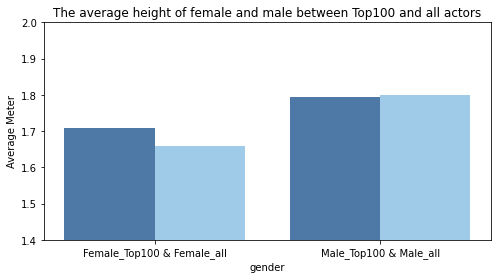

In [55]:
y1 = [female_height_average, male_height_average]
y2 = [all_female_height_average, all_male_height_average]
x = np.arange(len(y1))
width = 0.4
color1 = ["#4E79A7"]
color2 = ["#A0CBE8"]
plt.figure(figsize=(8,4))
plt.ylim(1.40, 2.00)
plt.bar(x=x, height=y1, width=width, color=color1)
plt.bar(x=x+width, height=y2, width=width, color=color2)
plt.title('The average height of female and male between Top100 and all actors')
plt.xticks(x+width/2, ['Female_Top100 & Female_all', 'Male_Top100 & Male_all'])
plt.xlabel('gender')
plt.ylabel('Average Meter')

Accroding to the above result, we find that the average height of male between Top100 and all actors seems to be very similar, so we do an additional T-test for it.

In [56]:
print(stats.ttest_ind(all_female_height_correct, female_height_correct))
print(stats.ttest_ind(all_male_height_correct, male_height_correct))

Ttest_indResult(statistic=-1.789147544311883, pvalue=0.07364340046714411)
Ttest_indResult(statistic=0.5049640885114878, pvalue=0.613599791610447)


##### The p-value of T-test is `0.61`, which shows that they are different in fact. So we can find that for female actors, who are in Top100 are usualy taller, but for male actors, who are in Top100 almost the same as the average or even shorter than average. It is a fact that taller people are more likely to become an actor or appear in the movies. Furtherly we can make a conclusion that Society has broad height requirements for male actors, but it often has higher requirements for women. #####